# ***Siamese Based Approach for Image Similarity***

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# split to test and validation
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=.5, random_state=0)

# prepare train and test sets
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.
val_images = val_images / 255.
test_images = test_images / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
label_mapper = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

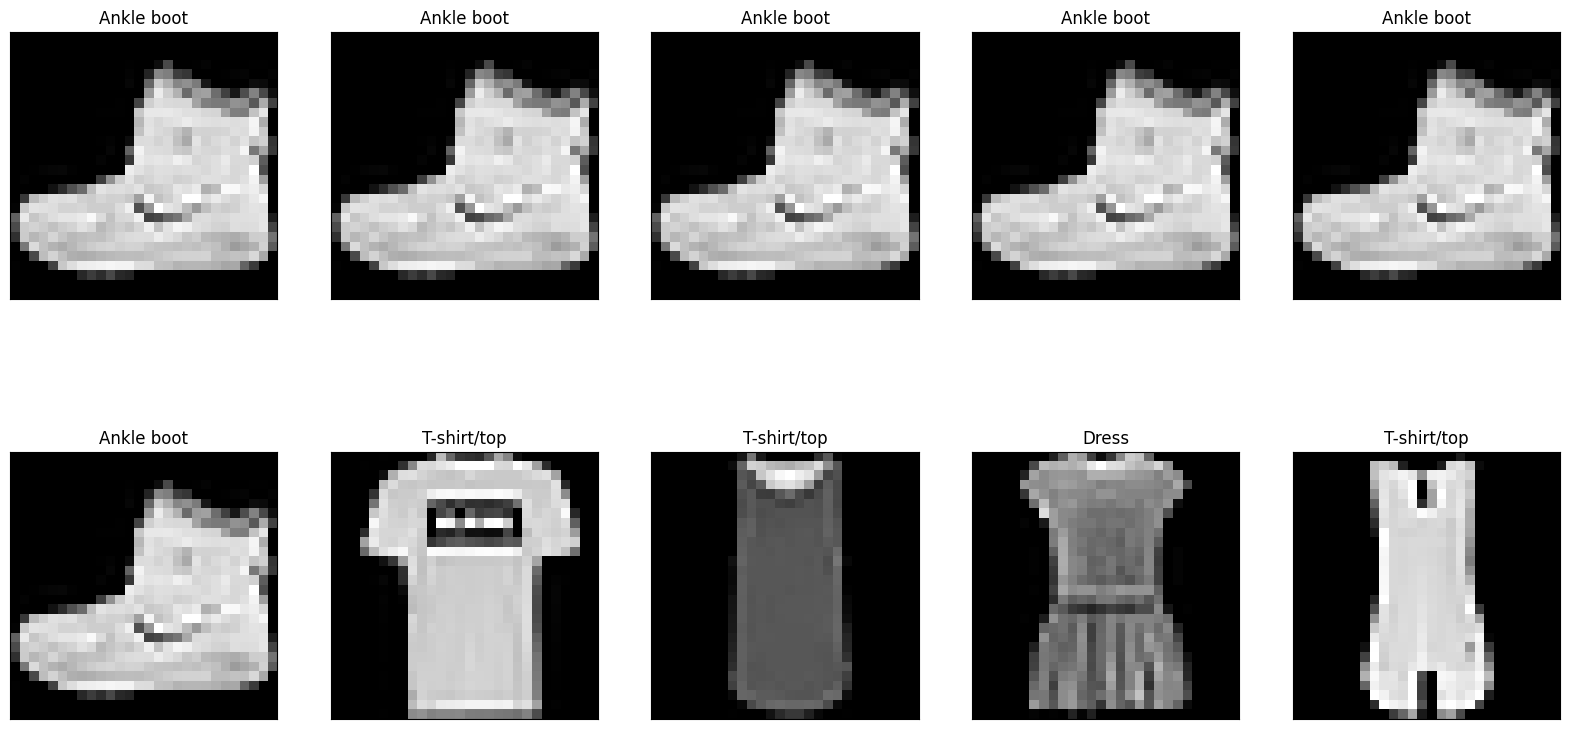

In [3]:
from matplotlib import pyplot as plt

row = 2
col = 5
_, axs = plt.subplots(row,col, figsize=(row * 10, col * 2))

for i in range(row):
    for j in range(col):
        temp_image = train_images[i * j]
        temp_image *= 255.
        axs[i,j].set_title(label_mapper[train_labels[i * j]])
        axs[i,j].imshow(temp_image, cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        del temp_image
plt.show()

In [4]:
import random
import numpy as np

def create_pairs(images, labels):
    """
    Create a positive and negative pair images

    Parameter
    ----------
    images: numpy array of images
    labels: numpy array of labels

    Return
    ----------
    pair_images: numpy array of random paired image
    pair_labels: numpy array of binary value (1 is positive, 0 is negative)
    """

    pair_images, pair_labels = [], []
    n = min([len(labels[l]) for l in range(10)]) - 1

    for l in range(10):
        for i in range(n):
            # create positive pair image
            z1, z2 = labels[l][i], labels[l][i + 1]
            pair_images += [[images[z1], images[z2]]]

            inc = random.randrange(1, 10)
            dn = (l + inc) % 10

            # create negative pair image
            z1, z2 = labels[l][i], labels[dn][i]
            pair_images += [[images[z1], images[z2]]]
            pair_labels += [1,0]
    return np.array(pair_images), np.array(pair_labels)

def create_pairs_on_set(images, labels):
    """
    Create a set for training data

    Parameter
    ----------
    images: numpy array of images
    labels: numpy array of labels

    Return
    ----------
    pairs: numpy array of random paired image
    y: numpy array of binary value (1 is positive, 0 is negative)
    """

    digit = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit)
    y = y.astype('float32')
    return pairs, y

In [5]:
# create pairs on train, validation and test sets
train_image_pairs, train_label_pairs = create_pairs_on_set(train_images, train_labels)
val_image_pairs, val_label_pairs = create_pairs_on_set(val_images, val_labels)
test_image_pairs, test_label_pairs = create_pairs_on_set(test_images, test_labels)

In [6]:
def show_image(anchor_image, image):
    """
    Display pair data

    Parameter
    ----------
    image: a set of image pair
    ax: an integer for axis

    Return
    ----------
    None
    """

    _, axs = plt.subplots(1,2)
    axs[0].imshow(anchor_image)
    axs[0].grid(False)
    axs[1].imshow(image)
    axs[1].grid(False)
    plt.show()

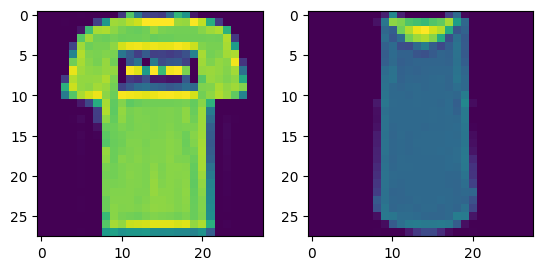

The train pair is the same


In [7]:
# array index
index = 0

# show images at this index
show_image(train_image_pairs[index][0], train_image_pairs[index][1])
print('The train pair is', 'the same' if train_label_pairs[index] == 1 else 'not the same')

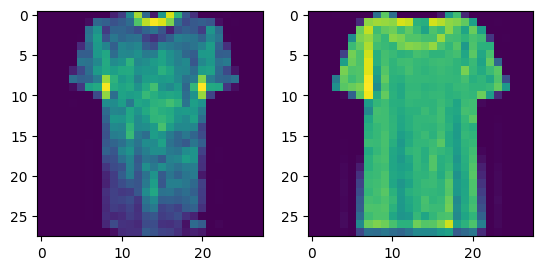

The validation pair is the same


In [8]:
show_image(val_image_pairs[index][0], val_image_pairs[index][1])
print('The validation pair is', 'the same' if val_label_pairs[index] == 1 else 'not the same')

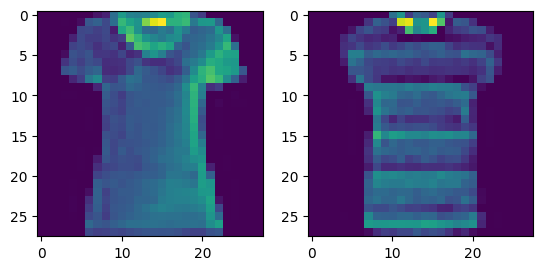

The test pair is the same


In [9]:
show_image(test_image_pairs[index][0], test_image_pairs[index][1])
print('The test pair is', 'the same' if test_label_pairs[index] == 1 else 'not the same')

In [10]:
from tensorflow import keras
from keras import Model
from keras import layers
from tensorflow.keras.utils import plot_model

class BaseNetwork(Model):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.flatten = layers.Flatten(name='flatten')
        self.d1 = layers.Dropout(.2, name='dropout_1')
        self.fc1 = layers.Dense(256, activation='relu', name='fully_1')
        self.d2 = layers.Dropout(.2, name='dropout_2')
        self.fc2 = layers.Dense(128, activation='relu', name='fully_2')

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.d1(x)
        x = self.fc1(x)
        x = self.d2(x)
        return self.fc2(x)

base_network = BaseNetwork()

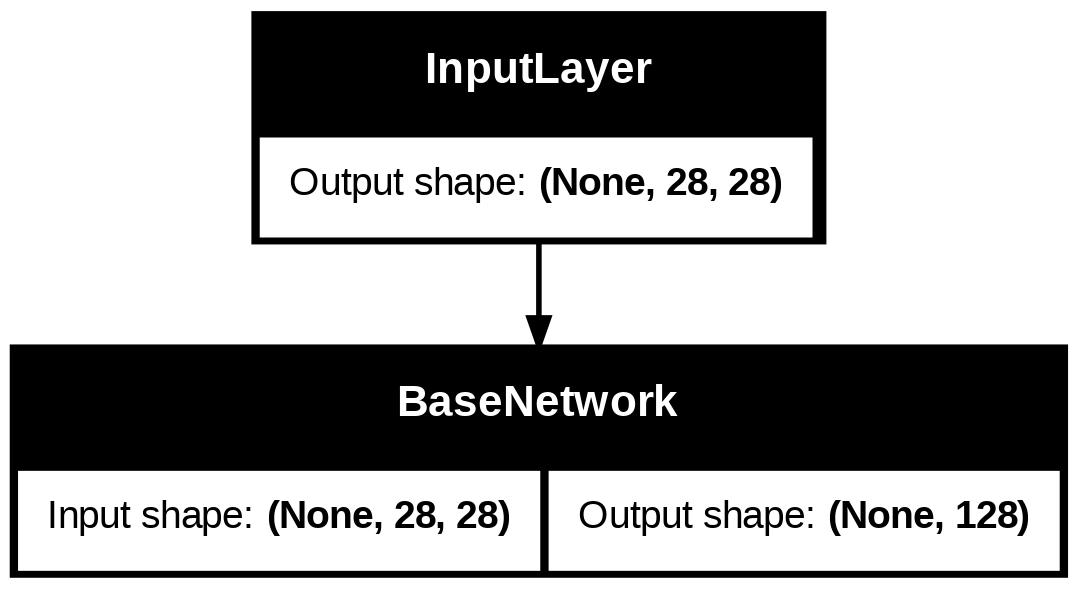

In [11]:
input_shape = train_images[0].shape
inputs = layers.Input(shape=input_shape)

# create base model and display model layer
output = base_network(inputs)
base_model = Model(inputs, output)
plot_model(base_model, show_shapes=True, to_file='base-model.png')

In [12]:
from tensorflow.keras import backend as K

def euclidean(vect):
    """
    Calculate the euclidean distance between vector

    Parameter
    ----------
    vect:

    Return
    ----------
    squared root sum:
    """

    x, y = vect
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_output_shape(shapes):
    """
    Get shape of vector

    Paramter
    ----------
    shapes: shapes of 2 vector

    Return
    euclidean output shape: (row from vector 1, 1)
    """

    shape1, shape2 = shapes
    return (shape1[0], 1)

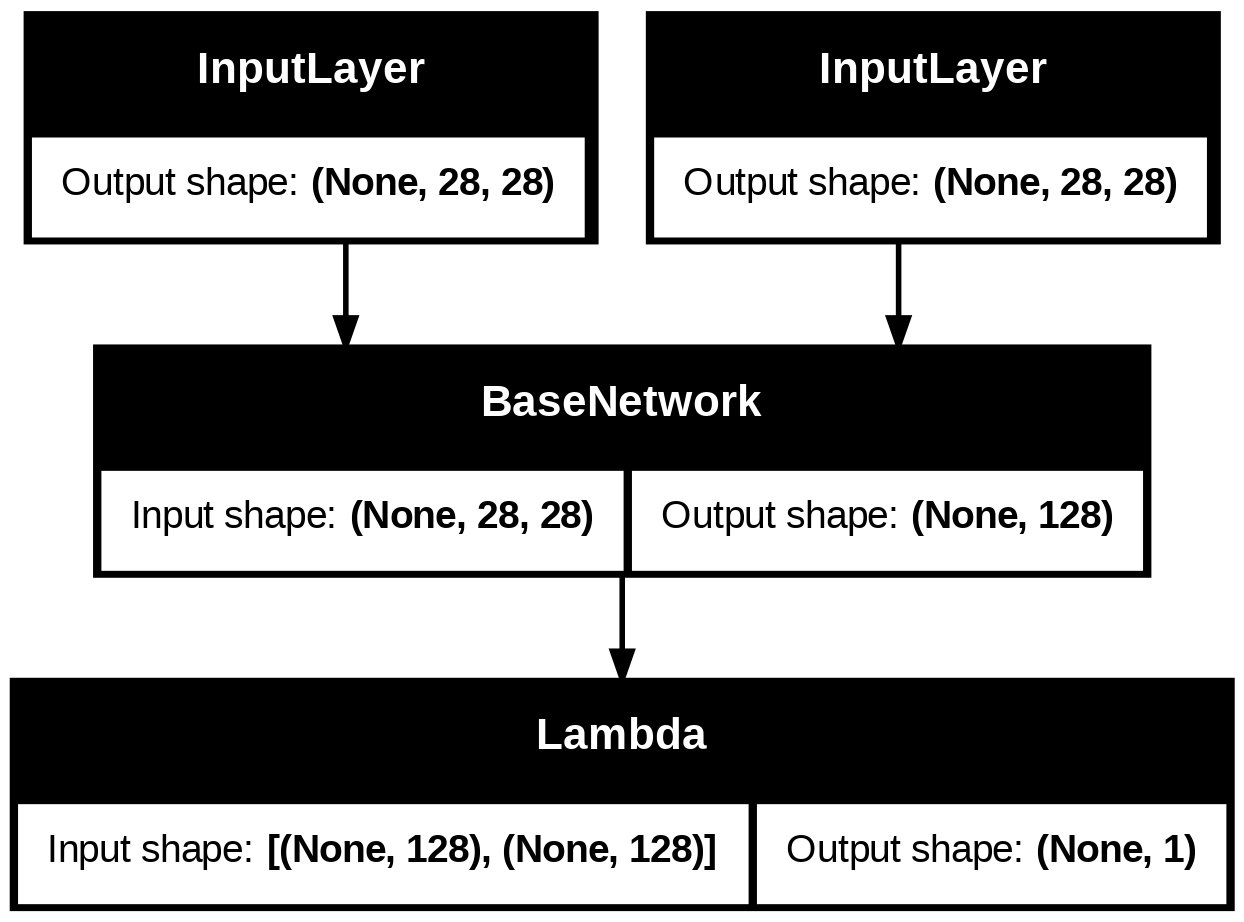

In [13]:
# define the input and output layer for left network
left_input = layers.Input(shape=input_shape, name='left_input')
left_output = base_network(left_input)

# define the input and output layer for right network
right_input = layers.Input(shape=input_shape, name='right_input')
right_output = base_network(right_input)

# measure similarity between vector
output = layers.Lambda(euclidean, name='output_layer', output_shape=euclidean_output_shape)([left_output, right_output])
model = Model([left_input, right_input], output)
plot_model(model, show_shapes=True, to_file='siamese-model.png')

In [14]:
def contrastive_loss_with_margin(margin):
    """
    Calculate contrastive loss with margin

    Parameter
    ----------
    margin: constant number [0-1]

    Return
    ----------
    contrastive_loss: function
    """

    def contrastive_loss(y_true, y_pred):
        """
        Calculate contrastive loss

        Parameter
        ----------
        y_true: ground truth label
        y_pred: prediction label

        Return
        ----------
        contrastive loss: (y_true * squared prediction + (1 - y_true) * squared margin)
        """

        squared_pred = K.square(y_pred)
        squared_margin = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * squared_pred + (1 - y_true) * squared_margin)
    return contrastive_loss

In [15]:
optimizer = keras.optimizers.RMSprop()
loss = contrastive_loss_with_margin(margin=1)

In [16]:
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ left_input (InputLayer)   │ (None, 28, 28)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ right_input (InputLayer)  │ (None, 28, 28)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ base_network              │ (None, 128)            │        233,856 │ left_input[0][0],      │
│ (BaseNetwork)             │                        │                │ right_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Lambda)     │ (None, 1)              │              0 │ base_network[1][0],    │
│                           │                        │                │ base_network[2][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 233,856 (913.50 KB)

 Trainable params: 233,856 (913.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    [train_image_pairs[:, 0], train_image_pairs[:, 1]],
    train_label_pairs,
    epochs=20,
    batch_size=256,
    validation_data=([val_image_pairs[:, 0], val_image_pairs[:, 1]], val_label_pairs)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 202936090319392597868544.0000 - val_loss: 0.1134
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 3947840445373416904589312.0000 - val_loss: 0.0958
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 264926842153454792605696.0000 - val_loss: 0.0898
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 50714508482662753107968.0000 - val_loss: 0.0866
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 449022645849299695435776.0000 - val_loss: 0.0835
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 364632142390201260441600.0000 - val_loss: 0.0817
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 678969309121027466330112.0000 - val_loss: 0.0816
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 3118394992005241439780864.0000 - val_loss: 0.0808
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 1269869682693711333425152.0000 - val_loss: 0.0795

In [18]:
def compute_accuracy(y_true, y_pred):
    """
    Compute binary accuracy with fixed threshold

    Parameter
    ----------
    y_true: ground truth label
    y_pred: predicted label

    Return
    ----------
    accuracy: mean prediction
    """

    yhat = y_pred.ravel() < .5
    return np.mean(yhat == y_true)

In [19]:
# compute validation accuracy
y_pred_val = model.predict([val_image_pairs[:,0], val_image_pairs[:,1]])
val_accuracy = compute_accuracy(val_label_pairs, y_pred_val)

# compute test accuracy
y_pred_test = model.predict([test_image_pairs[:,0], test_image_pairs[:,1]])
test_accuracy = compute_accuracy(test_label_pairs, y_pred_test)

print("val_accuracy: {} - test_accuracy: {}".format(val_accuracy, test_accuracy))

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
val_accuracy: 0.9026427061310782 - test_accuracy: 0.9020661157024793


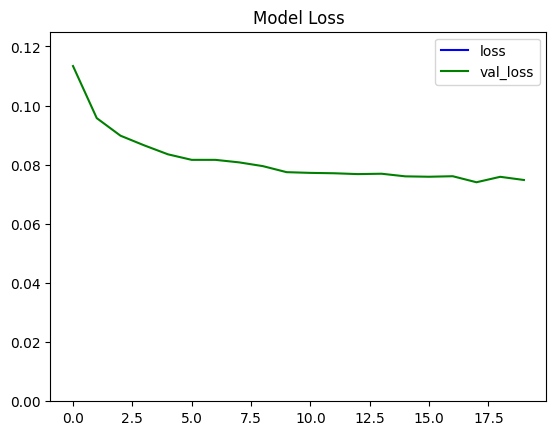

In [20]:
def plot_training_step(metric, title, ylim=1):
    """
    Visualize training step

    Parameter
    ----------
    metric: metric to be visualized
    title: title of the plot
    ylim: Optional, limit of the y axis

    Return
    ----------
    None
    """

    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric], color='blue', label=metric)
    plt.plot(history.history['val_' + metric], color='green', label='val_' + metric)
    plt.legend([metric, 'val_' + metric], loc='upper right')
    plt.show()

plot_training_step('loss', 'Model Loss', .125)

In [21]:
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    """
    Visualize image with distance

    Parameter
    ----------
    left: numpy array left image on pair
    right: numpy array right image on pair
    predictions: distance prediction between image
    labels: ground truth label
    title: plot title
    n: total pair want to visualize

    Return
    ----------
    None
    """

    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28 * n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5:
            t.set_color('red') # bad predictions in red
        else:
            t.set_color('green')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28 * n])
    plt.imshow(right)

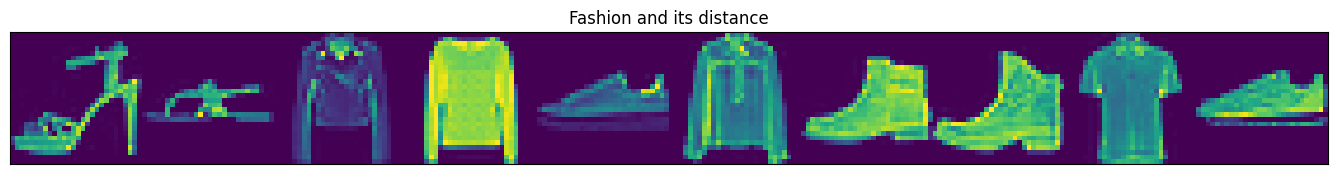

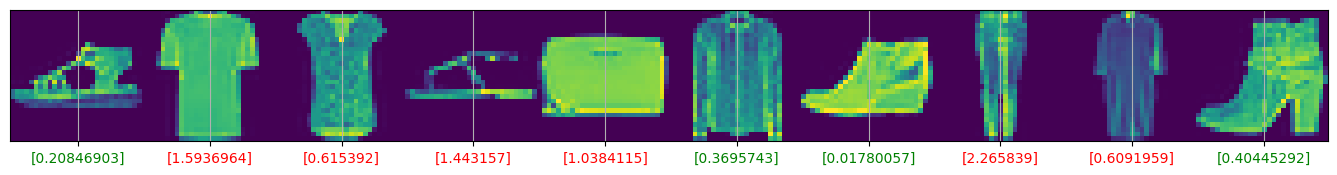

In [22]:
y_pred = np.squeeze(y_pred_test)
idx = np.random.choice(len(y_pred_test), size=10)
display_images(
    test_image_pairs[:, 0][idx],
    test_image_pairs[:, 1][idx],
    y_pred_test[idx],
    test_label_pairs[idx],
    "Fashion and its distance",
    10
)

In [23]:
model.save("siamese_model.h5")


Validation Set Metrics:

Model Evaluation Metrics:
-------------------------
Accuracy: 0.903
Precision: 0.885
Recall: 0.926
F1-Score: 0.905
Average Precision: 0.958

Precision@K:
  P@1: 1.000
  P@5: 1.000
  P@10: 1.000

Recall@K:
  R@1: 0.000
  R@5: 0.001
  R@10: 0.002

Test Set Metrics:

Model Evaluation Metrics:
-------------------------
Accuracy: 0.902
Precision: 0.882
Recall: 0.928
F1-Score: 0.905
Average Precision: 0.958

Precision@K:
  P@1: 1.000
  P@5: 1.000
  P@10: 1.000

Recall@K:
  R@1: 0.000
  R@5: 0.001
  R@10: 0.002


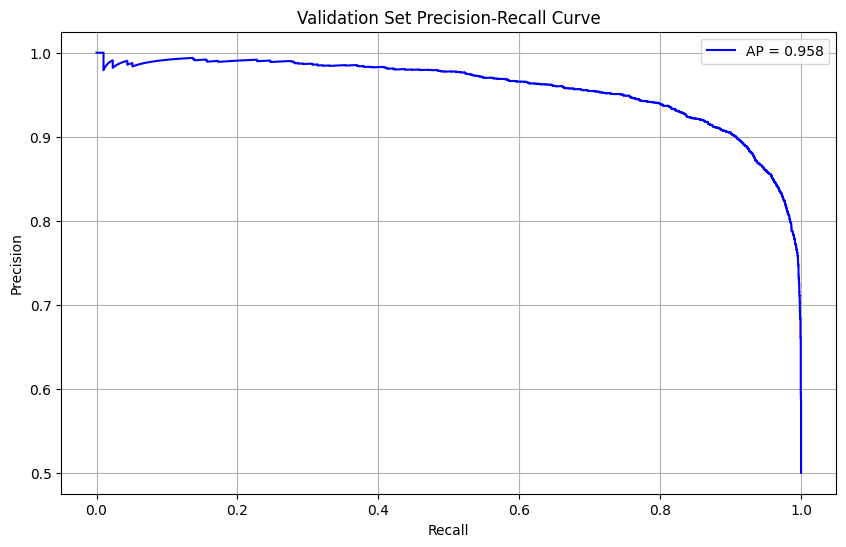

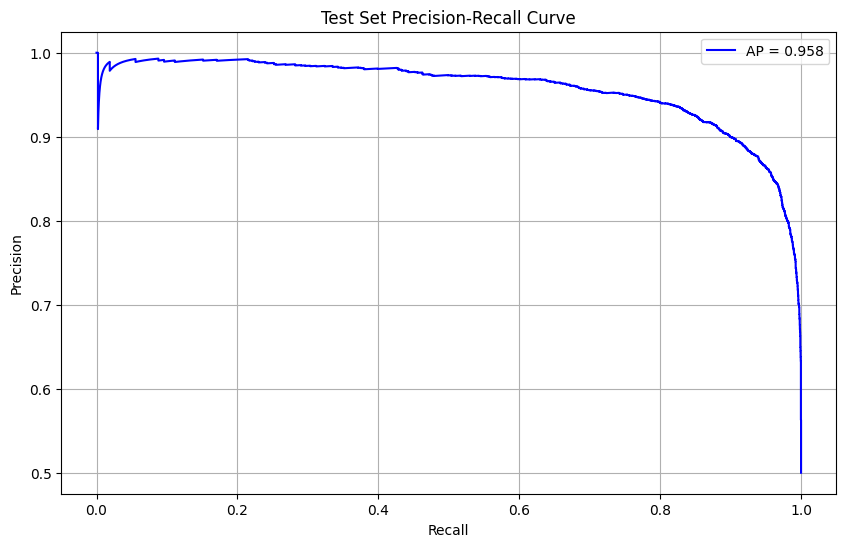

In [24]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def evaluate_siamese_model(y_true, y_pred_distances, threshold=0.5):
    """
    Evaluate Siamese network performance using various metrics

    Parameters:
    -----------
    y_true : array-like
        Ground truth labels (0 for different pairs, 1 for similar pairs)
    y_pred_distances : array-like
        Predicted distances from the Siamese network
    threshold : float, optional
        Distance threshold for binary classification

    Returns:
    --------
    dict
        Dictionary containing various evaluation metrics
    """
    # Convert distances to binary predictions using threshold
    y_pred_binary = (y_pred_distances.ravel() < threshold).astype(int)

    # Calculate basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='binary')
    accuracy = accuracy_score(y_true, y_pred_binary)

    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_true, -y_pred_distances.ravel())
    average_precision = average_precision_score(y_true, -y_pred_distances.ravel())

    # Calculate retrieval metrics at different K values
    k_values = [1, 5, 10]
    precision_at_k = {}
    recall_at_k = {}

    # Sort predictions by confidence (distance)
    sorted_indices = np.argsort(y_pred_distances.ravel())

    for k in k_values:
        top_k_indices = sorted_indices[:k]
        precision_at_k[k] = np.mean(y_true[top_k_indices] == 1)
        recall_at_k[k] = np.sum(y_true[top_k_indices] == 1) / np.sum(y_true == 1)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average_precision': average_precision,
        'precision_at_k': precision_at_k,
        'recall_at_k': recall_at_k,
        'pr_curve': (precisions, recalls, thresholds)
    }

    return metrics

def plot_precision_recall_curve(metrics, title="Precision-Recall Curve"):
    """
    Plot the precision-recall curve

    Parameters:
    -----------
    metrics : dict
        Dictionary containing evaluation metrics including PR curve data
    title : str, optional
        Title for the plot
    """
    precisions, recalls, _ = metrics['pr_curve']

    plt.figure(figsize=(10, 6))
    plt.plot(recalls, precisions, 'b-', label=f'AP = {metrics["average_precision"]:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def print_metrics_summary(metrics):
    """
    Print a summary of all evaluation metrics

    Parameters:
    -----------
    metrics : dict
        Dictionary containing evaluation metrics
    """
    print("\nModel Evaluation Metrics:")
    print("-------------------------")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1-Score: {metrics['f1_score']:.3f}")
    print(f"Average Precision: {metrics['average_precision']:.3f}")
    print("\nPrecision@K:")
    for k, v in metrics['precision_at_k'].items():
        print(f"  P@{k}: {v:.3f}")
    print("\nRecall@K:")
    for k, v in metrics['recall_at_k'].items():
        print(f"  R@{k}: {v:.3f}")

# Calculate metrics for validation and test sets
val_metrics = evaluate_siamese_model(val_label_pairs, y_pred_val)
test_metrics = evaluate_siamese_model(test_label_pairs, y_pred_test)

# Print summaries
print("\nValidation Set Metrics:")
print_metrics_summary(val_metrics)
print("\nTest Set Metrics:")
print_metrics_summary(test_metrics)

# Plot precision-recall curves
plot_precision_recall_curve(val_metrics, "Validation Set Precision-Recall Curve")
plot_precision_recall_curve(test_metrics, "Test Set Precision-Recall Curve")